In [1]:
from monitorcontrol import get_monitors

for i, monitor in enumerate(get_monitors()):
    with monitor:
        brightness = monitor.get_luminance()
        contrast = monitor.get_contrast()
        print(f"Monitor {i}:\n  - Brightness: {brightness}\n  - Contrast: {contrast}")

Monitor 0:
  - Brightness: 45
  - Contrast: 74


In [2]:
def set_monitor_settings(brightness: int, contrast: int):
    for monitor in get_monitors():
        with monitor:
            monitor.set_luminance(brightness)
            monitor.set_contrast(contrast)

set_monitor_settings(brightness=95, contrast=90)

In [3]:
import os

import paho.mqtt.client as mqtt
from dotenv import load_dotenv
import time

load_dotenv()

def on_connect(client, userdata, flags, reason_code, properties):
    client.subscribe("homeassistant/light/color_temp_k")
    client.subscribe("homeassistant/light/brightness_pct")

def on_message(client, userdata, msg):
    value = msg.payload.decode()
    print(f"Topic: {msg.topic}, Value: {value}")

client = mqtt.Client(mqtt.CallbackAPIVersion.VERSION2)
client.on_connect = on_connect
client.on_message = on_message
client.connect(host=os.environ["HA_MQTT_Address"])
client.username_pw_set(
    username=os.environ["HA_MQTT_Username"],
    password=os.environ["HA_MQTT_Password"]
)
client.loop_start()
time.sleep(5)      
client.loop_stop() 

Topic: homeassistant/light/color_temp_k, Value: 2256


<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

In [4]:
# Ask for a refresh
client.publish(topic="homeassistant/light/refresh")

In [5]:
monitor_config = {
    "brightness": {
        "max": 100,
        "min": 3,
        "offset": 0,
    },
    "contrast": {
        "max": 92,
        "min": 60,
        "offset": 0,
    }
}

def percent_to_monitor_value(min: int, max: int, percent: int):
    val = max - min
    val *= percent / 100
    val = round(val)
    return min + val

percent_to_monitor_value(monitor_config["brightness"]["min"], monitor_config["brightness"]["max"], 50)

51

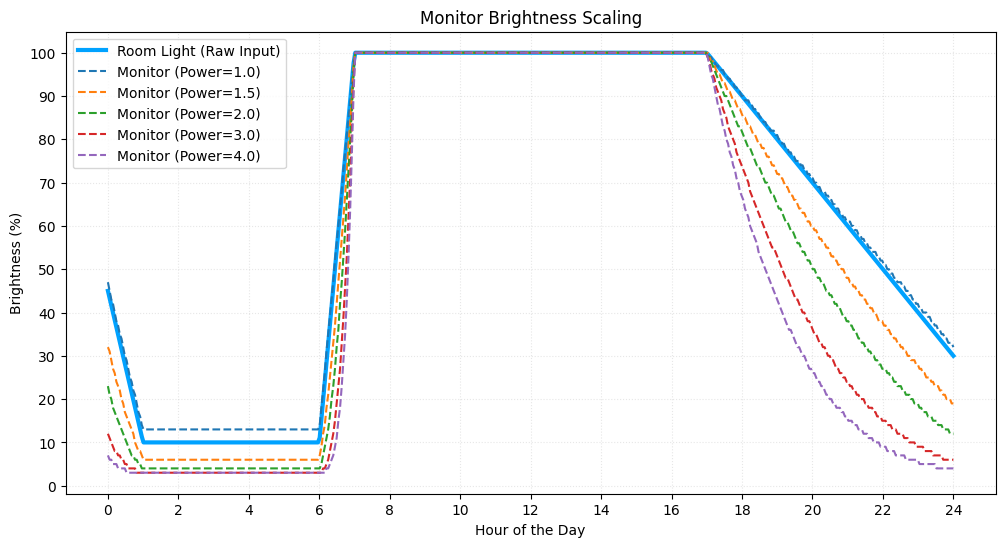

In [26]:
import numpy as np
import matplotlib.pyplot as plt

time_points = [0, 1, 6, 7, 17, 24]
room_brightness = [45, 10, 10, 100, 100, 30]

hours = np.linspace(0, 24, 500)

input_curve = np.interp(hours, time_points, room_brightness)

def percent_to_monitor_value(light_level: int, power: float, min_val: int, max_val: int) -> int:
    normalized = light_level / 100.0
    curved = np.power(normalized, power)
    scaled_value = min_val + (curved * (max_val - min_val))
    return int(round(scaled_value))

plt.figure(figsize=(12, 6))

plt.plot(hours, input_curve, label="Room Light (Raw Input)", linewidth=3, color='#00a2ff')

for power in [1.0, 1.5, 2.0, 3.0, 4.0]:
    scaled_curve = [percent_to_monitor_value(val, power, 3, 100) for val in input_curve]
    plt.plot(hours, scaled_curve, label=f"Monitor (Power={power})", linestyle='--')

# Formatting
plt.title("Monitor Brightness Scaling")
plt.xlabel("Hour of the Day")
plt.ylabel("Brightness (%)")
plt.xticks(np.arange(0, 25, 2))
plt.yticks(np.arange(0, 110, 10))
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend()
plt.show()